## Part 1:

In [187]:
import re

# a)
# six-digit date (DDMMYY) followed by 4 digit identifier (IIII)
# show either DDMMYYIIII or DDMMYY-IIII format

cpr_pattern = r'\b((?:0[1-9]|[12][0-9]|3[01]))((?:0[1-9]|1[0-2]))(\d{2})-?(\d{4})\b'

def extract_cpr(cpr_str: str):
    match = re.fullmatch(cpr_pattern, cpr_str)
    if match:
        return match.groups()
    else:
        return None

test_cprs = ["0102031234", "010203-1234", "3112995678", "311299-5678", "1234567890"]

for cpr in test_cprs:
    result = extract_cpr(cpr)
    if result:
        print(f"Valid CPR: {cpr} -> DD: {result[0]}, MM: {result[1]}, YY: {result[2]}, IIII: {result[3]}")
    else:
        print(f"Invalid CPR: {cpr}")

Valid CPR: 0102031234 -> DD: 01, MM: 02, YY: 03, IIII: 1234
Valid CPR: 010203-1234 -> DD: 01, MM: 02, YY: 03, IIII: 1234
Valid CPR: 3112995678 -> DD: 31, MM: 12, YY: 99, IIII: 5678
Valid CPR: 311299-5678 -> DD: 31, MM: 12, YY: 99, IIII: 5678
Invalid CPR: 1234567890


In [188]:
# b)
# Function to return relevant centuary
def centuarty(yy: int, iiii: int) -> int:
    if 1 <= iiii <= 3999:
        return 1900
    elif 4000 <= iiii <= 4999:
        return 2000 if 0 <= yy <= 36 else 1900
    elif 5000 <= iiii <= 8999:
        return 2000 if 0 <= yy <= 57 else 1800
    elif 9000 <= iiii <= 9999:
        return 2000 if 0 <= yy <= 36 else 1900
    else:
        raise ValueError("Invalid CPR identifier (IIII)")
    
# Test cases
test_cases = [
    (99, 1234),  # 1900
    (15, 4500),  # 2000
    (50, 4500),  # 1900
    (30, 6000),  # 2000
    (70, 6000),  # 1800
    (20, 9500),  # 2000
    (80, 9500),  # 1900
]

for yy, iiii in test_cases:
    print(f"YY: {yy}, IIII: {iiii} -> Century: {centuarty(yy, iiii)}")

YY: 99, IIII: 1234 -> Century: 1900
YY: 15, IIII: 4500 -> Century: 2000
YY: 50, IIII: 4500 -> Century: 1900
YY: 30, IIII: 6000 -> Century: 2000
YY: 70, IIII: 6000 -> Century: 1800
YY: 20, IIII: 9500 -> Century: 2000
YY: 80, IIII: 9500 -> Century: 1900


## Part 2:

In [189]:
import pandas as pd

# 1-2)
# Read csv file
df = pd.read_csv("news_sample.csv")

# display head
#print(df.head())


In [190]:
# 3)
# 3. Inspect the DataFrame
print("DataFrame Info:")
print(df.info(), "\n")

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        250 non-null    int64  
 1   id                250 non-null    int64  
 2   domain            250 non-null    object 
 3   type              238 non-null    object 
 4   url               250 non-null    object 
 5   content           250 non-null    object 
 6   scraped_at        250 non-null    object 
 7   inserted_at       250 non-null    object 
 8   updated_at        250 non-null    object 
 9   title             250 non-null    object 
 10  authors           170 non-null    object 
 11  keywords          0 non-null      float64
 12  meta_keywords     250 non-null    object 
 13  meta_description  54 non-null     object 
 14  tags              27 non-null     object 
 15  summary           0 non-null      float64
dtypes: float64(2), int64(2), obj

As we can see from above when we print out df.info() out, I get provided a summary of my Data, which is useful for serveral purposes:

# Understanding structure of the data
* Number of rows and columns: here we see 250 rows and 16 (0 indexed) columns.
* Column names and data types: Helps me understand what kind of that every column has (float64, int64, object).
* Memory usage, The news_sample.csv takes 31.4 KB of memory.

# Identifying missing data
* the type, authors, meta_description, and tags columns have missing values.
* the keywords and summary columns are completely empty, as seen with 0 non-null.

# Unnecessary columns
* unnamed: 0 looks unnecessary
* keywords and summary are empty

In [191]:
# 4. clean data using clean_tex() that uses regular expressions

def clean_text(text):
    if not isinstance(text, str):  # Ensure input is string
        return text
    # all words must be lowercased
    text = text.lower() 
    # it should not contain multiple white spaces, tabs, or new lines
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Replace common date formats
    text = re.sub(r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b', '<DATE>', text)
    # Month DD, YYYY
    text = re.sub(r'\b(?:january|february|march|april|may|june|july|august|september|october|november|december) \d{1,2}, \d{4}\b', '<DATE>', text, flags=re.IGNORECASE)
    # YYYY-MM-DD with optional timestamp
    text = re.sub(r'\b\d{4}-\d{2}-\d{2}(?: \d{2}:\d{2}:\d{2}(?:\.\d{1,6})?)?\b', '<DATE>', text)
    
    # Replace standalone numbers
    text = re.sub(r'\b\d+\b', '<NUM>', text)
    # Replace emails
    text = re.sub(r'\b[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}\b', '<EMAIL>', text)
    # Replace URLs
    text = re.sub(r'\b(?:https?|ftp):\/\/[^\s/$.?#].[^\s]*\b', '<URL>', text)
    
    return text

# Apply cleaning function to text-based columns
df['content'] = df['content'].apply(clean_text)
df['title'] = df['title'].apply(clean_text)
df['meta_description'] = df['meta_description'].apply(clean_text)
df['tags'] = df['tags'].apply(clean_text)

In [192]:
# 5)
import unicodedata
from cleantext import clean

def clean_text(text):
    if not isinstance(text, str):  # Ensure input is string
        return text
    
    # Normalize Unicode characters to closest ASCII equivalent
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8")
    
    text = clean(text,
                 lower=True,  # Convert to lowercase
                 no_urls=True,  # Replace URLs with <URL>
                 no_emails=True,  # Replace emails with <EMAIL>
                 no_numbers=True,  # Replace numbers with <NUM>
                 no_punct=False,  # Keep punctuation (unless needed to remove)
                 replace_with_url='<URL>',
                 replace_with_email='<EMAIL>',
                 replace_with_number='<NUM>',
                 replace_with_punct="")
    
    text = re.sub(r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b', '<DATE>', text)  # Replace common date formats
    text = re.sub(r'\b(?:january|february|march|april|may|june|july|august|september|october|november|december) \d{1,2}, \d{4}\b', '<DATE>', text, flags=re.IGNORECASE)  # Month DD, YYYY
    text = re.sub(r'\b\d{4}-\d{2}-\d{2}\b', '<DATE>', text)  # YYYY-MM-DD
    
    return text

# Apply cleaning function to text-based columns
df['content'] = df['content'].apply(clean_text)
df['title'] = df['title'].apply(clean_text)
df['meta_description'] = df['meta_description'].apply(clean_text)
df['tags'] = df['tags'].apply(clean_text)

print("DataFrame Info:")
print(df.info(), "\n")

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        250 non-null    int64  
 1   id                250 non-null    int64  
 2   domain            250 non-null    object 
 3   type              238 non-null    object 
 4   url               250 non-null    object 
 5   content           250 non-null    object 
 6   scraped_at        250 non-null    object 
 7   inserted_at       250 non-null    object 
 8   updated_at        250 non-null    object 
 9   title             250 non-null    object 
 10  authors           170 non-null    object 
 11  keywords          0 non-null      float64
 12  meta_keywords     250 non-null    object 
 13  meta_description  54 non-null     object 
 14  tags              27 non-null     object 
 15  summary           0 non-null      float64
dtypes: float64(2), int64(2), obj

## Part 3

unique words in raw text: 24465
unique words in cleaned text: 24465


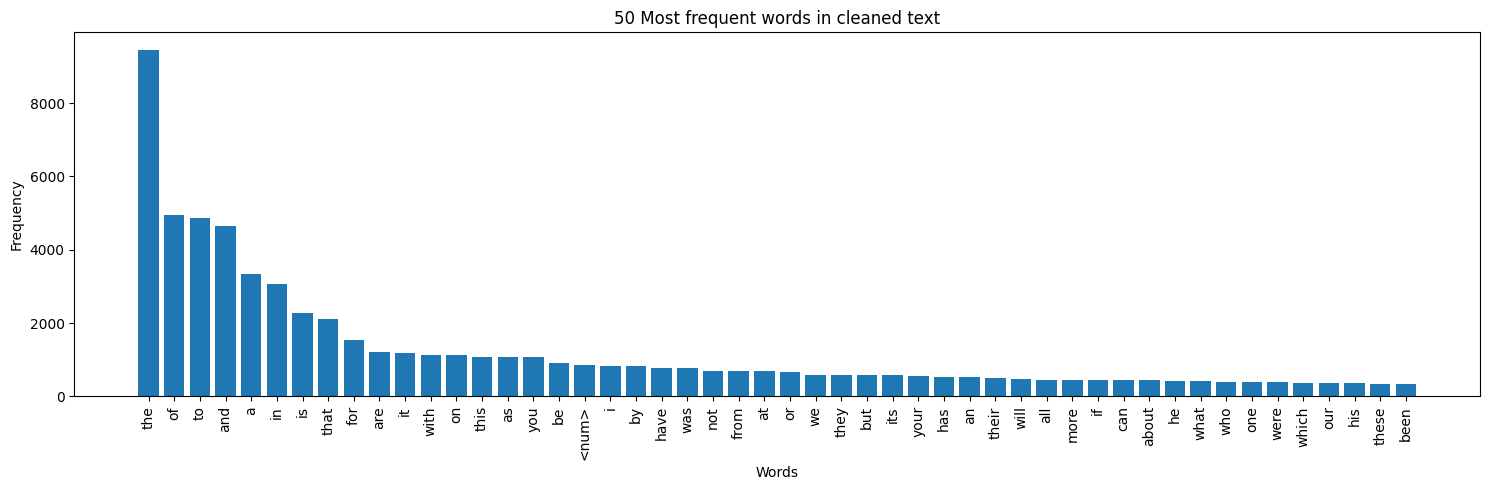

In [193]:
# 1

import matplotlib.pyplot as plt
from collections import Counter

def clean_text_lib(text):
   return clean(text, lower=True, no_line_breaks=True, no_urls=True, no_emails=True, no_numbers=True)


# 2: Clean the data 
df['clean_content'] = df['content'].apply(lambda x: clean_text_lib(x) if isinstance(x, str) else "")

# 3: get all raw data from 'content'
raw_text = " ".join(df['content'].dropna().tolist())
raw_tokens = raw_text.split()
unique_raw_words = set(raw_tokens)
print("unique words in raw text:", len(unique_raw_words))

# Get all cleaned text from the new "clean_content" column
clean_text_all = " ".join(df['clean_content'].dropna().tolist())
clean_tokens = clean_text_all.split()
unique_clean_words = set(clean_tokens)
print("unique words in cleaned text:", len(unique_clean_words))

# number of each word in cleaned text
word_freq = Counter(clean_tokens)
most_common_50 = word_freq.most_common(50)

# Unzip the list of tuples for plotting
words, frequencies = zip(*most_common_50)

# Plot the 50 most frequent words
plt.figure(figsize=(15, 5))
plt.bar(words, frequencies)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("50 Most frequent words in cleaned text")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
